In [1]:
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
import scipy as sp
import scipy.optimize
import pandas as pd
import neural_tangents as nt
import functools
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

from jax import random, config
from jax import jit, grad, vmap, random
from jax.tree_util import tree_flatten
from neural_tangents import stax

from jax.example_libraries import optimizers

2025-05-24 15:30:03.479507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-24 15:30:03.492082: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-24 15:30:03.495863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-24 15:30:10.149265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def NN_func(params, X, gamma):
    W, z = params
    P, D = X.shape 
    N = z.shape[0]

    h = X @ W / jnp.sqrt(D) #(P, D) x (D, N)
    phi = h * (h > 0.0)
    f = (phi @ z) / (N * gamma)
    return f


def make_apply_fn(gamma):
    def apply_fn_closure(params, X):
        # X will be shape (P, D)
        return NN_func(params, X, gamma)  # (P,)
    return apply_fn_closure


def NN_train(X_train, y_train, X_test, y_test, gamma, lamb, N=5000, lr=1e-4, steps=10000):
    # Shapes
    P, D = X_train.shape  # (P, D)
    Ptest = X_test.shape[0]

    # Initialize parameters
    # W is shape (D, N) => X @ W -> (P, N)
    W = random.normal(random.PRNGKey(0), (D, N))
    z = random.normal(random.PRNGKey(1), (N,))

    params = [W, z]
    
    apply_fn_closure = make_apply_fn(gamma)

    ntk_fn = nt.batch(nt.empirical_ntk_fn(f=apply_fn_closure, trace_axes=(), implementation=2), batch_size=100)

    X_all = jnp.vstack([X_train, X_test])   # (P + Ptest, D)
    C_all = X_all @ X_all.T /D
    h = X_train @ W / jnp.sqrt(D)            # (P + Ptest, N)
    phi = h * (h > 0.0)           # (P + Ptest, N)
    Phi0 = (phi @ phi.T) / N
    g = (h > 0.0) * z[jnp.newaxis, :]
    G0 = (g @ g.T) / N
    K0 = Phi0 + G0 * C_all[:P, :P]
    
    h_test = X_test @ W / jnp.sqrt(D)            
    phi_test = h_test * (h_test > 0.0)           
    g_test   = (h_test > 0.0) * z[jnp.newaxis, :] 
    Phi_test_train = (phi_test @ phi.T) / N 
    G_test_train   = (g_test   @ g.T)    / N
    K0_test = Phi_test_train + G_test_train * C_all[P:,:P] 

    loss = lambda params, X, y: 0.5 * jnp.sum((NN_func(params, X, gamma) - y) ** 2)
    grad_loss = grad(loss)

    train_losses = []
    test_losses = []

    for n in range(steps):
        train_loss = 0.5 * jnp.mean((NN_func(params, X_train, gamma) - y_train) ** 2)
        test_loss = jnp.mean((NN_func(params, X_test, gamma) - y_test) ** 2)

        sys.stdout.write(f'\r Iteration {n + 1}/{steps}: Train Loss = {train_loss:.6f}, Test Loss = {test_loss:.6f}')

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        grads = grad_loss(params, X_train, y_train)
        dW, dz = grads

        W += -lr * N * gamma**2 * grads[0] - lr * lamb * W
        z += -lr * N * gamma**2 * grads[1] - lr * lamb * z
        params = [W, z]
        
    # Compute final phi and Phi for train+test sets
    h = X_train @ W / jnp.sqrt(D)  
    g = (h > 0.0) * z[jnp.newaxis, :]
    phi = h * (h > 0.0)
    Phi = (phi @ phi.T) / N 
    G = (g @ g.T) / N
    entk = (Phi + G * C_all[:P,:P])
    
    h_test = X_test @ W / jnp.sqrt(D)            
    phi_test = h_test * (h_test > 0.0)           
    g_test   = (h_test > 0.0) * z[jnp.newaxis, :] 
    Phi_test_train = (phi_test @ phi.T) / N 
    G_test_train   = (g_test   @ g.T)    / N
    final_K_test_train = Phi_test_train + G_test_train * C_all[P:,:P]
    
    I = jnp.eye(P)
    y_test_pred = final_K_test_train  @ jnp.linalg.solve(entk + 2 * lamb * I , y_train)
    y_test_init = K0_test @ jnp.linalg.solve(K0 + 2 * lamb * I, y_train)
    y_NN_test = NN_func(params, X_test, gamma)

    return train_losses, test_losses, Phi, Phi0, h, z, y_NN_test, y_test_pred, y_test_init, entk


In [3]:
# Load dataset 
from teachers import * 

P = 300
Ptest = 1980
lambda0 = 1.0
seedx = 15
C, X_train, y_train, X_test, y_test = load_mnist(P, Ptest, lambda0, seed=seedx)

y_train = np.where(y_train == 0, -1, y_train)
y_test = np.where(y_test == 0, -1, y_test)

/n/home10/clauditi/miniconda/envs/new_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-24 15:32:15.204104: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-05-24 15:32:15.617831: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `d

In [4]:
# Try to compute NTK kernel at initialization

N = 5000
P, D = X_train.shape 
gamma = 1.0

W = random.normal(random.PRNGKey(0), (D, N))
z = random.normal(random.PRNGKey(1), (N,))
params = [W, z]  

In [10]:
 train ,test, Phi, Phi0, h, z,  y_NN_test, y_test_pred, y_test_init, entk = NN_train(X_train, y_train, X_test, y_test, 4.0, 2.0)

 Iteration 10000/10000: Train Loss = 0.002608, Test Loss = 0.021162

([], [])

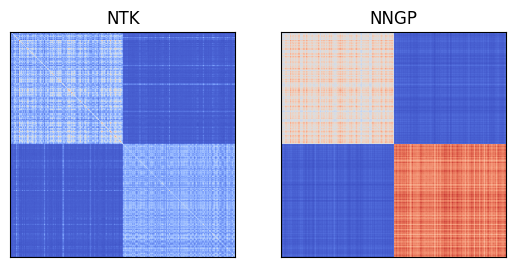

In [8]:
sort = np.argsort(y_train)
kernel = Phi[:P,:P]

plt.subplot(1,2,1)
plt.imshow(entk[sort][:,sort], cmap = 'coolwarm')
plt.title('NTK')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(kernel[sort][:,sort], cmap = 'coolwarm')
plt.title('NNGP')
plt.xticks([])
plt.yticks([])

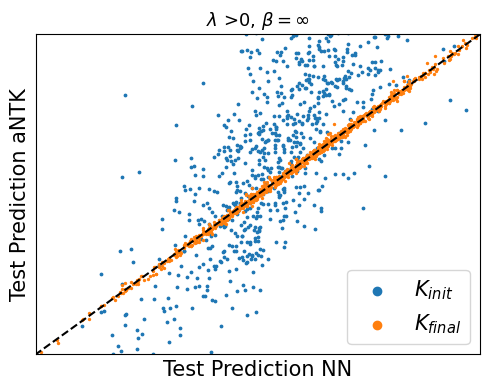

In [11]:
plt.figure(figsize=(5,4))
plt.scatter(y_NN_test, y_test_init, s=3.0)
plt.scatter(y_NN_test, y_test_pred, s=2.0)
plt.scatter([], [], color = 'C0', label = r'$K_{init}$')
plt.scatter([], [], color = 'C1', label = r'$K_{final}$')
y_plot = np.linspace(-1.5,1.5, 2000)
plt.plot(y_plot, y_plot, '--', color = 'black')
plt.xlabel('Test Prediction NN', fontsize = 15)
plt.ylabel(r'Test Prediction aNTK', fontsize = 15)
plt.title(r'$\lambda$ >0, $\beta = \infty$', fontsize=13)

plt.xlim([-1.37,-0.70])
plt.ylim([-1.37,-0.70])
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=15)
plt.tight_layout()
#plt.savefig('ntk_scatterplot_lambda1_mnist.png',dpi=300)
plt.show()

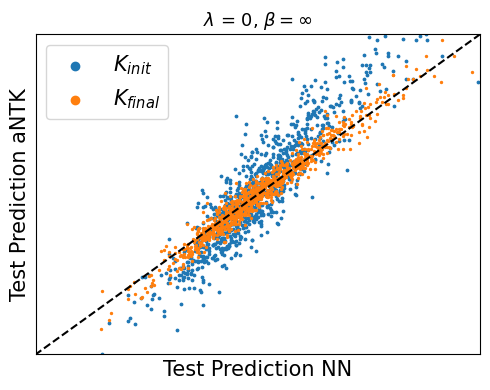

In [6]:
plt.figure(figsize=(5,4))
plt.scatter(y_NN_test, y_test_init, s=3.0)
plt.scatter(y_NN_test, y_test_pred, s=2.0)
plt.scatter([], [], color = 'C0', label = r'$K_{init}$')
plt.scatter([], [], color = 'C1', label = r'$K_{final}$')
y_plot = np.linspace(-1.5,1.5, 2000)
plt.plot(y_plot, y_plot, '--', color = 'black')
plt.xlabel('Test Prediction NN', fontsize = 15)
plt.ylabel(r'Test Prediction aNTK', fontsize = 15)
plt.title(r'$\lambda$ = 0, $\beta = \infty$', fontsize=13)

plt.xlim([-1.37,-0.60])
plt.ylim([-1.37,-0.60])
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=15)
plt.tight_layout()
#plt.savefig('ntk_scatterplot_lambda0_mnist.png',dpi=300)
plt.show()

In [12]:
# Bayesian case, Langevin dynamics 
# deep Langevin dynamics 
import optax

def nonlinear_fn(params, X, gamma0):

    W0 = params[0]
    D = X.shape[0]
    h = W0 @ X / jnp.sqrt(D)  
    #h = jnp.tanh(h)
    h = h * (h > 0.0)
    for i, W in enumerate(params[1:-1]):
        h = 1/jnp.sqrt(W.shape[1]) * W @ h
        #h = jnp.tanh(h)
        h = h * (h > 0.0)

    N = params[-1].shape[0]
    f = h.T @ params[-1] / (N * gamma0)
    return f

def nonlinear_fn_reps(params, X, gamma0):

    W0 = params[0]
    D = X.shape[0]
    h = W0 @ X / jnp.sqrt(D)
    h = jnp.tanh(h)
    #h = h * (h > 0.0)
    all_h = [ h.T @ h / h.shape[0] ]
    for i, W in enumerate(params[1:-1]):
        h = 1/jnp.sqrt(W.shape[1]) * W @ h
        #h = jnp.tanh(h)
        h = h * (h > 0.0)
        all_h += [ h.T @ h / h.shape[0] ]
    N = params[-1].shape[0]
    f = h.T @ params[-1] / (N * gamma0)
    return f, all_h

def deep_nonlinear(X_train, y_train, X_test, y_test, N, L, T, eta, gamma0, beta, seed = 2, center = False, sigma=0.0):

    M = X_train.shape[0]

    Ws = [random.normal(random.PRNGKey(seed), (N, M) )]

    for i in range(L-1):
        Ws += [ random.normal(random.PRNGKey(seed+i), ( N ,  N ) ) ]

    Ws += [ random.normal(random.PRNGKey(seed+L), (N,) ) ]

    P = y_train.shape[0]
    Ptest = y_test.shape[0]

    reg_loss_fn = jit(lambda p: 0.5 * N * gamma0**2 * jnp.sum( ( nonlinear_fn(p, X_train, gamma0)  - y_train )**2 ) +  0.5/beta * optimizers.l2_norm(p)**2 )

    test_loss_fn = jit(lambda p: jnp.mean( ( nonlinear_fn(p, X_test, gamma0)  - y_test )**2 ))

    solver = optax.noisy_sgd(learning_rate = eta , eta = 2.0 / beta / eta, gamma= 0.0)

    grad_fn = jit( grad(reg_loss_fn) )
    opt_state = solver.init( Ws )

    train_losses = []
    test_losses = []

    params = Ws.copy()

    H_avgs = []
    all_cs = []
    count = 0
    
    W = params[0]
    D = X_train.shape[0]
    h = W @ X_train / jnp.sqrt(D) # (N, D) x (D, P) = (N, P)
    phi = h * (h > 0.0)
    Phi = phi.T @ phi /N
    
    # train test kernel
    h_test = W @ X_test / jnp.sqrt(D)
    phi_test = h_test * (h_test > 0.0) # (N, Ptest)
    Phi_traintest = phi_test.T @ phi /N # (Ptest, P)
    I = jnp.eye(P)
    
    y_test_init = Phi_traintest  @ jnp.linalg.solve(Phi + I/beta , y_train)

    for t in range(T):

        train_losses += [ reg_loss_fn(params) ]
        test_losses += [test_loss_fn(params)]
        
        sys.stdout.write(f'\r Iteration {t + 1}/{T}: Test Loss = {test_loss_fn(params):.6f}')
        
                
        if t % 10:
          _, Hs = nonlinear_fn_reps(params, X_train, gamma)
          all_cs += [ [jnp.dot(y_train, H @ y_train) for H in Hs] ]
          if count == 0:
            H_avgs = [ H for H in Hs ]
          else:
            H_avgs = [  count / (count+1) * H_avgs[i] + 1/(count+1) * H for i, H in enumerate(Hs) ]

          count += 1
        grads = grad_fn(params)
        updates, opt_state = solver.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        
    y_NN_test = nonlinear_fn(params, X_test, gamma0)
    W = params[0]
    D = X_train.shape[0]
    h = W @ X_train / jnp.sqrt(D) # (N, D) x (D, P) = (N, P)
    phi = h * (h > 0.0)
    Phi = phi.T @ phi /N
    
    # train test kernel
    h_test = W @ X_test / jnp.sqrt(D)
    phi_test = h_test * (h_test > 0.0) # (N, Ptest)
    Phi_traintest = phi_test.T @ phi /N # (Ptest, P)
    I = jnp.eye(P)
    
    y_test_pred = Phi_traintest  @ jnp.linalg.solve(Phi + I/beta , y_train)    

    return train_losses, test_losses, H_avgs, all_cs, params, Ws, y_NN_test, y_test_init, y_test_pred

In [13]:
beta = 100
N = 2048
L = 1
eta = 0.0005
gamma = 1.0
T = 50000
X_train = X_train.T
X_test = X_test.T

train_losses, test_losses, H_avg, all_cs, params, Ws, y_NN_test, y_test_init, y_test_pred = deep_nonlinear(X_train, y_train, X_test, y_test, N, L, T, eta, gamma, beta, seed=2)

 Iteration 50000/50000: Test Loss = 0.015807

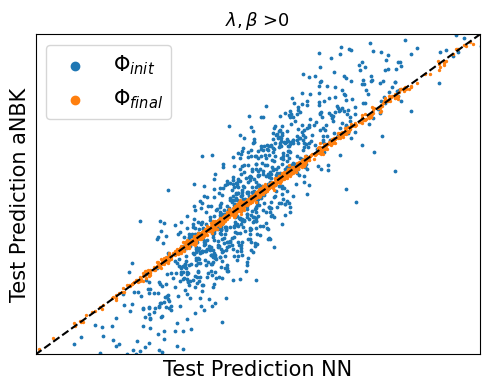

In [14]:
plt.figure(figsize=(5,4))
plt.scatter(y_NN_test, y_test_init, s=3.0)
plt.scatter(y_NN_test, y_test_pred, s=2.0)
plt.scatter([], [], color = 'C0', label = r'$\Phi_{init}$')
plt.scatter([], [], color = 'C1', label = r'$\Phi_{final}$')
y_plot = np.linspace(-1.5,1.5, 2000)
plt.plot(y_plot, y_plot, '--', color = 'black')
plt.xlabel('Test Prediction NN', fontsize = 15)
plt.ylabel(r'Test Prediction aNBK', fontsize = 15)
plt.title(r'$\lambda, \beta$ >0', fontsize=13)

plt.xlim([-1.3,-0.65])
plt.ylim([-1.3,-0.65])
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=15)
plt.tight_layout()
#plt.savefig('bayes_scatterplot_lambdabeta_mnist.png',dpi=300)
plt.show()